# N-Queens problem

## The problem

The N-Queens problem is to find all arrangements of N queens on a N*N chess board such that no two queens can attack each other. 
One possible arrangement is shown below.

![One possible solution of N-Queens for a 4*4 chessboard](https://acrogenesis.com/or-tools/documentation/user_manual/_images/sol_4x4_b.png)

## The classical approach

The N-Queens problem has been solved classically using various approaches.
Some of them are listed below:
    * Bactracking
    * Greedy algorithms
    * Brute force
The best classical approach so far is the greedy approach which solves the problem in O($ n^3 $) but it fails to find all possible arrangements.   

## The quantum approach

In order to find a solution of the N-Queens problem, each queen must satisfy 3 criteria:
    * Row criteria
    * Column criteria
    * Diagonal Criteria
We represent each box in the chess board by a qubit such that first four qubits correspond to the first row of the chess board then we find the arrangements(by applying appropriate gates) which follow all three criteria. 


We have simulated the N-Queens problem for N=4.

In [1]:
from qiskit import *
from qiskit.compiler import transpile, assemble

In [2]:
circuit = QuantumCircuit(25,25)

## Row criteria

In order to satisfy the row criteria the total number of queens in each row should be one. To reduce our search space, instead of starting with superposition of all possible arrangements of queens on a chess board, we start with arrangements which satisy the row criteria. The initial state is essentially a superposition of all the states in which each row contains one queen.

In [3]:
# Row-Criteria
for i in range(0,13,4):
    circuit.h(i)
    circuit.h(i+3)
    
    circuit.x(i)
    circuit.x(i+3)
    
    circuit.ccx(i, i+3, i+1)
    
    circuit.x(i)
    circuit.x(i+3)
    
    circuit.ccx(i, i+3, i+2)
    
    circuit.cx(i+2, i)
    circuit.cx(i+2, i+3)

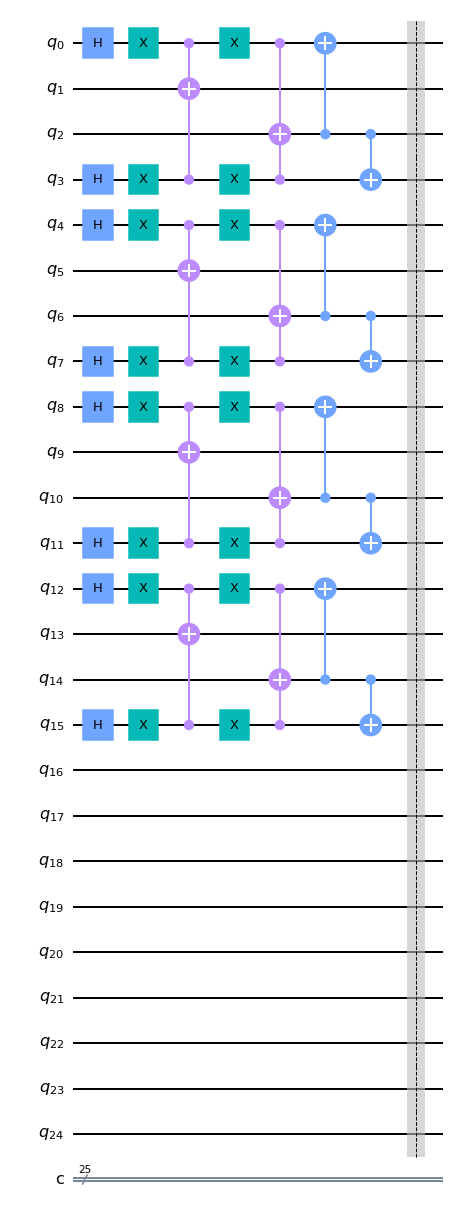

In [4]:
circuit.barrier()
circuit.draw(output='mpl')

## Column criteria

In order to satisfy the column criteria each column must contain only one queen. To perform a column check we take an ancilla qubit and apply hadamard to it then apply a controlled z gate controlled by the corresponding column qubit followed by a hadamard. This ensures that if the column has odd number of queens the ancilla qubit will be in |1> state and |0> otherwise. 
Since the arrangements already follow row criteria we can say that all the ancilla qubits will be in the state |1> only when the arrangement satisfies column criteria. 


In [5]:
# Column-Criteria
for i in range(3):
    circuit.h(i+16)
    
    for j in range(4):
        circuit.cz(i+16, 4*j+i)
        
    circuit.h(i+16)

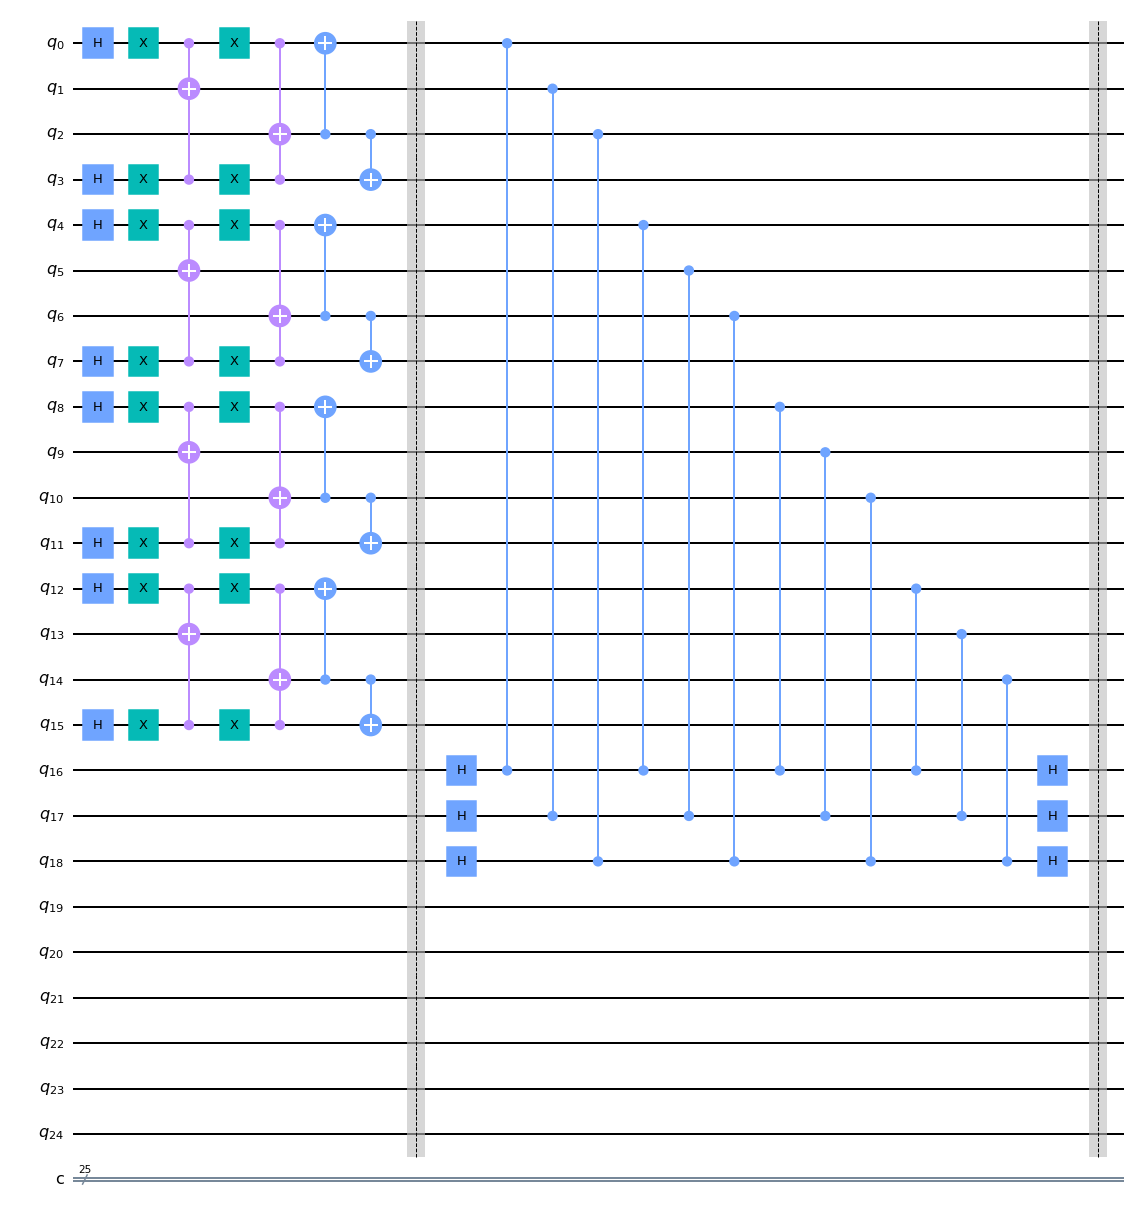

In [6]:
circuit.barrier()
circuit.draw(output='mpl')

## Diagonal criteria

In order to satisfy the diagonal criteria, each diagonal must contain only either one or zero queen. We perform a diagonal check by initialising n*(n-1)/2 ancilla qubits in the |1> state and applying toffoli gates controlled by the diagonal qubits. In this way all the ancilla qubits will be in the state |1> only when the diagonal criteria is fulfilled. 

In [7]:
# Diagonal-Criteria
# initializing diagonal ancillas to |1>
for i in range(6):
    circuit.x(i+19)
 
count = 0        
for i in range(3):
    for j in range(3-i):
        for k in range(3-i):
            circuit.ccx(4*j+k, 4*j+5*(i+1)+k, 19+count+j)
            circuit.ccx(4*j+i+1+k, 4*j+4*(i+1)+k, 19+count+j)
    count = count+3-i

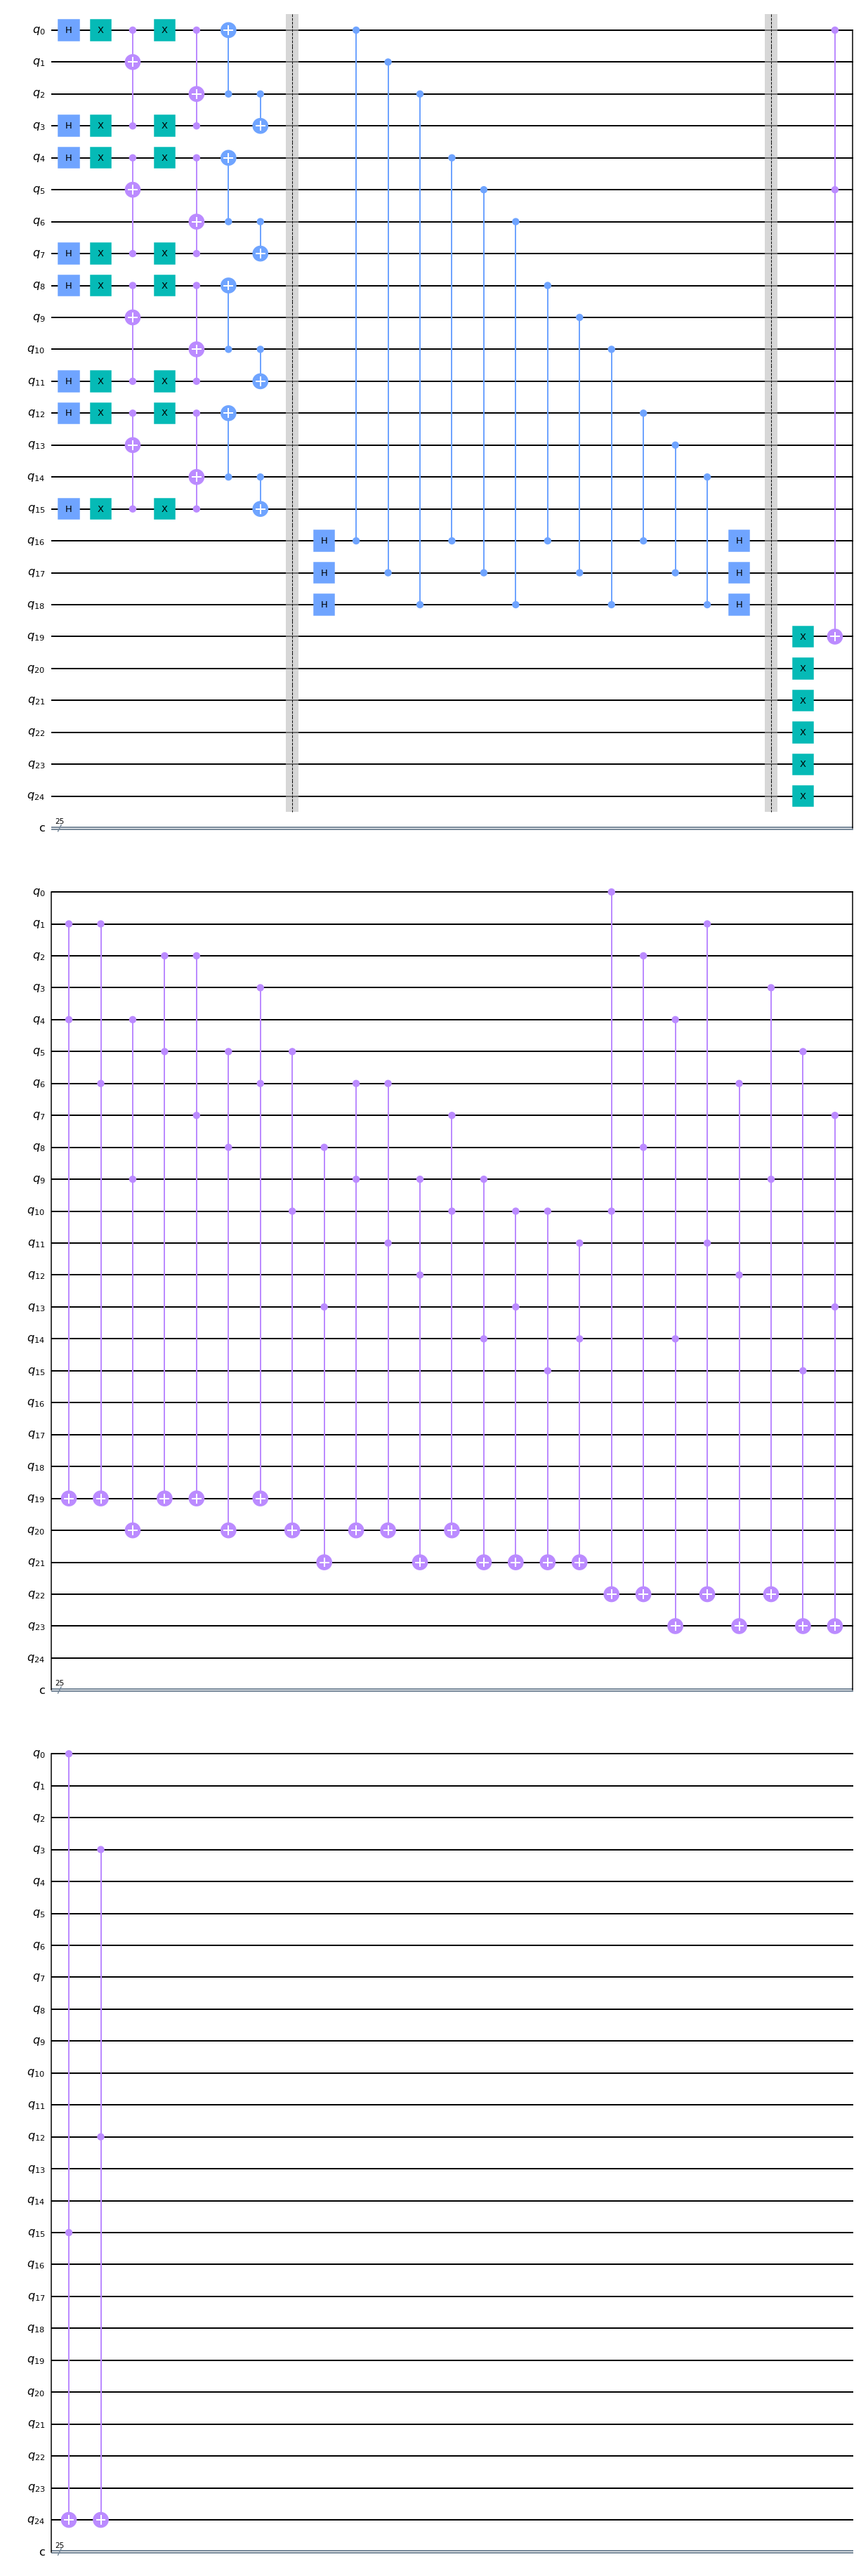

In [8]:
circuit.draw(output='mpl')

In [9]:
circuit.measure(range(25), range(25));

## Simulating the circuit 

In [10]:
IBMQ.load_account() 

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [11]:
IBMQ.providers() 
provider = IBMQ.get_provider(hub='ibm-q')

In [12]:
backend = provider.get_backend('ibmq_qasm_simulator')

In [13]:
mapped_circuit = transpile(circuit, backend=backend)
qobj = assemble(mapped_circuit, backend=backend, shots=1024)
job = backend.run(qobj)

C:\Users\pranj\AppData\Local\Programs\Python\Python39\lib\site-packages\qiskit\providers\ibmq\ibmqbackend.py:906: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  return super().run(circuits, job_name=job_name,


In [14]:
from qiskit.tools.monitor import job_monitor

In [15]:
job_monitor(job)

Job Status: job has successfully run


In [16]:
result = job.result()
counts = result.get_counts()
sol = list(counts.keys())

## Results

The outcome in which all the ancilla qubits are in the state |1> gives us the solution to our problem. 

In [17]:
outcomes = []
for i in sol:
    if(i[0:9] == '1'*9):
        outcomes.append(i[9:])

In [18]:
matrices = []
for i in outcomes:
    itr_matrix = []
    for j in range(4):
        row = [int(x)for x in i[4*j:4*j+4]]
        itr_matrix.append(row)
    matrices.append(itr_matrix)

In [19]:
from tkinter import *
from PIL import Image, ImageTk

In [20]:
root = Tk()
root.geometry("810x450")
root.title("QUEENtum")

# array for solution
solution1 = matrices[0]
solution2 = matrices[1]

# queen on white board
image_white = Image.open("white.jpg")
image_white = image_white.resize((79,79), Image.ANTIALIAS)
queen_white = ImageTk.PhotoImage(image_white)

# queen on black board
image_black = Image.open("black.jpg")
image_black = image_black.resize((79,79), Image.ANTIALIAS)
queen_black = ImageTk.PhotoImage(image_black)

# white box
bg_white = Image.open("bgwhite.jpg")
bg_white = bg_white.resize((79,79), Image.ANTIALIAS)
box_white = ImageTk.PhotoImage(bg_white)

# black box
bg_black = Image.open("bgblack.jpg")
bg_black = bg_black.resize((79,79), Image.ANTIALIAS)
box_black = ImageTk.PhotoImage(bg_black)

Heading = Frame(root)
Label(Heading, text="Solution 1",font="comicsansns 15", borderwidth=2, relief=RAISED, padx=30, pady=10).pack(side=LEFT,padx=125)
Label(Heading, text="Solution 2",font="comicsansns 15", borderwidth=2, relief=RAISED, padx=30, pady=10).pack(side=RIGHT,padx=125)
Heading.pack(pady=10)
# making board 1
board1 = Frame(root, width=320, height=320, borderwidth=5, relief=RAISED)

# making the boxes
for i in range(0,4):
    for j in range(0,4):
        if (i+j)%2 == 0:
            Label(board1, image=box_white, borderwidth=1, relief=RAISED).grid(row=i, column=j)
        else:
            Label(board1, image=box_black, borderwidth=1, relief=RAISED).grid(row=i, column=j)

# establishing the queen
for i in range(0,4):
    for j in range(0,4):
        if ((i+j)%2 == 0) and (solution1[i][j] == 1):
            Label(board1, image=queen_white, borderwidth=1, relief=RAISED).grid(row=i, column=j)
        elif ((i+j)%2 != 0) and (solution1[i][j] == 1):
            Label(board1, image=queen_black, borderwidth=1, relief=RAISED).grid(row=i,column=j)

board1.pack(padx=30, pady=10, side=LEFT)

# making board 2
board2 = Frame(root, width=320, height=320, borderwidth=5, relief=RAISED)

# making the boxes
for i in range(0,4):
    for j in range(0,4):
        if (i+j)%2 == 0:
            Label(board2, image=box_white, borderwidth=1, relief=RAISED).grid(row=i, column=j)
        else:
            Label(board2, image=box_black, borderwidth=1, relief=RAISED).grid(row=i, column=j)

# establishing the queen
for i in range(0,4):
    for j in range(0,4):
        if ((i+j)%2 == 0) and (solution2[i][j] == 1):
            Label(board2, image=queen_white, borderwidth=1, relief=RAISED).grid(row=i, column=j)
        elif ((i+j)%2 != 0) and (solution2[i][j] == 1):
            Label(board2, image=queen_black, borderwidth=1, relief=RAISED).grid(row=i,column=j)

board2.pack(padx=30, pady=10, side=RIGHT)
# icon of the gui
root.iconphoto(False,queen_black)
root.mainloop()